In [132]:
import healpy as hp
import numpy as np
import matplotlib.pyplot as plt

from scipy.special import iv as Iv #Modified Bessel function of the first kind of real order.
import scipy.special as sc

from scipy.stats import rice

from scipy.stats.mstats import gmean
from multiprocessing import Pool, cpu_count

import dynesty
from dynesty import utils as dyfunc
from dynesty import plotting as dyplot
%matplotlib inline

# import data

In [143]:
fres = np.array([2.3, 5, 23, 28, 33]); nu0 = gmean(fres)

In [133]:
total_P = np.load('/global/cscratch1/sd/jianyao/CBASS/Observations/homo_noise/totalP_s0_64_uK_RJ_000.npy')

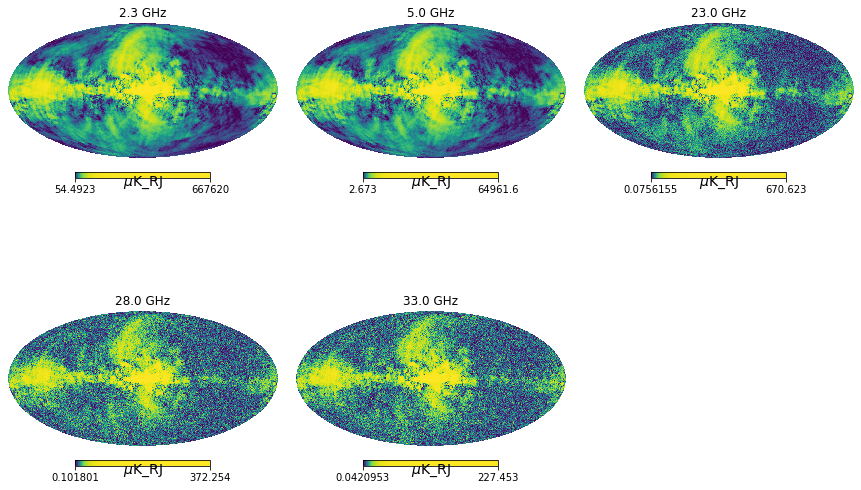

In [135]:
plt.figure(figsize = (12, 8))
hp.mollview(total_P[0], norm = 'hist', unit = '$\mu$K_RJ', sub = 231, title = '%s GHz' % fres[0]) 
hp.mollview(total_P[1], norm = 'hist', unit = '$\mu$K_RJ', sub = 232, title = '%s GHz' % fres[1]) 
hp.mollview(total_P[2], norm = 'hist', unit = '$\mu$K_RJ', sub = 233, title = '%s GHz' % fres[2]) 
hp.mollview(total_P[3], norm = 'hist', unit = '$\mu$K_RJ', sub = 234, title = '%s GHz' % fres[3]) 
hp.mollview(total_P[4], norm = 'hist', unit = '$\mu$K_RJ', sub = 235, title = '%s GHz' % fres[4]) 

In [145]:
P_nu0 = np.load('/global/cscratch1/sd/jianyao/CBASS/Foreground/P_nu0_s0_64_uK_RJ.npy')

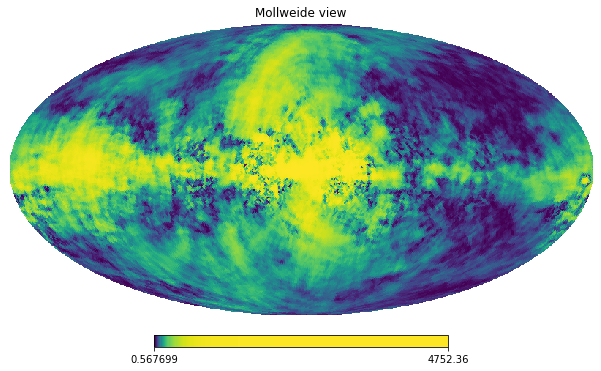

In [149]:
hp.mollview(P_nu0, norm = 'hist')

In [136]:
total_sigma = np.load('/global/cscratch1/sd/jianyao/CBASS/Noise/homo_noise/5_fre_sigma_P_64_uK_RJ.npy')

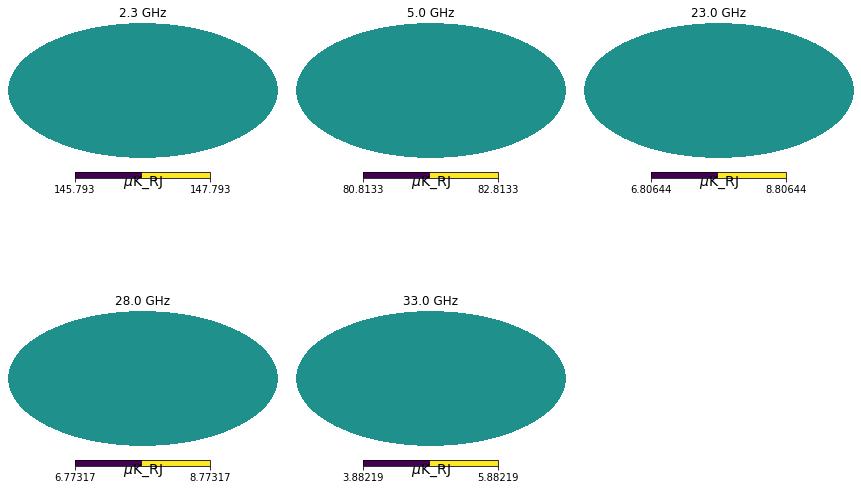

In [139]:
plt.figure(figsize = (12, 8))
hp.mollview(total_sigma[0], norm = 'hist', unit = '$\mu$K_RJ', sub = 231, title = '%s GHz' % fres[0]) 
hp.mollview(total_sigma[1], norm = 'hist', unit = '$\mu$K_RJ', sub = 232, title = '%s GHz' % fres[1]) 
hp.mollview(total_sigma[2], norm = 'hist', unit = '$\mu$K_RJ', sub = 233, title = '%s GHz' % fres[2]) 
hp.mollview(total_sigma[3], norm = 'hist', unit = '$\mu$K_RJ', sub = 234, title = '%s GHz' % fres[3]) 
hp.mollview(total_sigma[4], norm = 'hist', unit = '$\mu$K_RJ', sub = 235, title = '%s GHz' % fres[4]) 

In [138]:
total_sigma[:,0]

array([146.79320586,  81.81327411,   7.80643749,   7.77317173,
         4.88219032])

In [212]:
12*64*64*0.5/60

409.6

# Zero order Modified Bessel Function of the First Kind

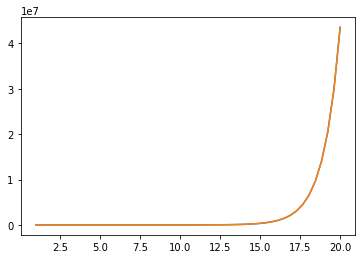

In [25]:
xs = np.linspace(1,20, 50)
plt.plot(xs, Iv(0, xs))
plt.plot(xs, sc.i0(xs))

# likelihood

In [144]:
total_P[:,100]

array([9.39651206e+03, 9.16184755e+02, 8.12108177e+00, 9.26611036e+00,
       5.32287158e+00])

In [240]:
def Pro(fre, index, A0, beta):
    
    p = total_P[fre][index]; 
    sigma = total_sigma[fre][index] #???????????????
    nu1 = fres[fre]
    
    exp = -(p**2 + (A0*(nu1/nu0)**(beta))**2)/2/sigma**2
    
    x = p*A0*(nu1/nu0)**(beta)/sigma**2
    pro = p/sigma**2*np.exp(exp)*Iv(0, x)
    
    return pro


# using scipy special function **rice** to improving the numerical stability of I0
# https://github.com/scipy/scipy/blob/v1.7.0/scipy/stats/_continuous_distns.py#L7220
def Pro_test(fre, index, A0, beta):
    nu1 = fres[fre]
    P = total_P[fre][index]; 
    
    P0 = A0*(nu1/nu0)**(beta)
    sigma = total_sigma[fre][index]
    
    pro = rice.pdf(P, P0/sigma, scale=sigma)
    return pro
    
    
index = 0; nu0 = gmean(fres)

Pro = Pro_test ## use modified pdf instead
def loglikeli(cube):
    A0 = cube[0];
    beta = cube[1];   
    pro0 = Pro(0, index, A0, beta)
    pro1 = Pro(1, index, A0, beta)
    pro2 = Pro(2, index, A0, beta)
    pro3 = Pro(3, index, A0, beta)
    pro4 = Pro(4, index, A0, beta)
    
#     print(pro0, pro1, pro2, pro3, pro4)
    L = (pro0*pro1*pro2*pro3*pro4)
#     print(L)
    if L == 0:
        logL = -1e30
        return logL
    else:
        return np.log(L)

In [241]:
P_nu0[index]

17.77469

In [ ]:
12*64**2

In [242]:
npara = 2; 

def prior(cube):
    A0 = cube[0]*100 # 0-100
    beta = cube[1]*2 - 4
    
    return [A0, beta]


# Run MC and plot

In [265]:
sampler = dynesty.NestedSampler(loglikeli, prior, npara, nlive=1000, bootstrap = 0)
sampler.run_nested(dlogz = 0.1)
results = sampler.results

iter: 6268 | +1000 | bound: 8 | nc: 1 | ncall: 45196 | eff(%): 16.081 | loglstar:   -inf < -19.346 <    inf | logz: -23.263 +/-    nan | dlogz:  0.000 >  0.100                                       

In [155]:
samples, weights = results.samples, np.exp(results.logwt - results.logz[-1])
resamples = dyfunc.resample_equal(samples, weights)

In [157]:
resamples.shape

(8702, 2)

In [158]:
np.mean(resamples[:,0])

64.3697831823126

In [159]:
np.mean(resamples[:,1])

-3.032877002730301

Text(0.5, 0.98, 'Pixel 0')

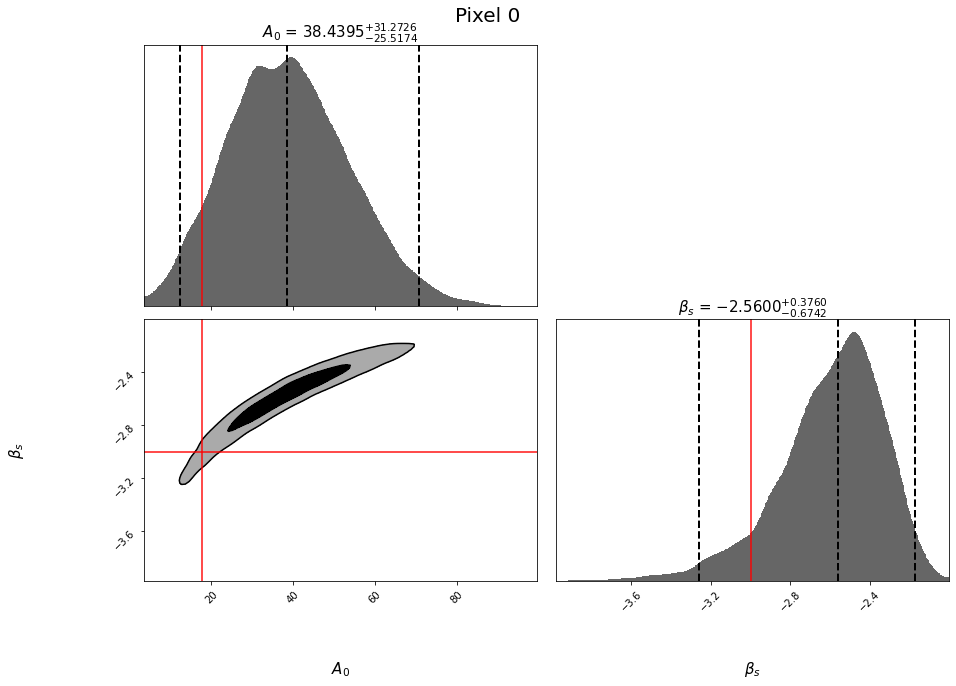

In [266]:
truth = np.array([P_nu0[index], -3]);sig1 = [0.16, 0.5, 0.84]; sig2 = [0.021, 0.5, 0.979];


labels = ['$A_0$', r'$\beta_s$']; 
fig, axes = plt.subplots(npara, npara, figsize=(15, 10))
axes = axes.reshape((npara, npara)) 

fig, ax = dyplot.cornerplot(results, truths=truth, fig = (fig, axes), title_fmt='.4f', title_kwargs = {'fontsize':15}, show_titles=True,
                 labels = labels,label_kwargs = {'fontsize':15}, quantiles = sig2, quantiles_2d = [0.4,0.85]) #0.1, 0.4, 0.65, 0.85
fig.suptitle("Pixel 0", fontsize="20")

In [ ]:
truth = np.array([0.05, -3.0, 1.558, 0.1]); sig1 = [0.16, 0.5, 0.84]; sig2 = [0.021, 0.5, 0.979];

for n in range(Nsim):
    
    labels = ['r', r'$\beta_s$',r'$\beta_d$', r'epislon']; 
    fig, axes = plt.subplots(npara, npara, figsize=(15, 10))
    axes = axes.reshape((npara, npara)) 

    fig, ax = dyplot.cornerplot(Results[n], truths=truth, fig = (fig, axes), title_fmt='.4f', show_titles=True,
                     labels = labels,quantiles = sig2, quantiles_2d = [0.4,0.85]) #0.1, 0.4, 0.65, 0.85

In [ ]:
12

# Results analysis

In [277]:
As_all = np.load('/global/cscratch1/sd/jianyao/CBASS/Results/s0_only_homo_noise/As.npy')
Beta_all = np.load('/global/cscratch1/sd/jianyao/CBASS/Results/s0_only_homo_noise/Beta.npy')

In [283]:
As_all[As_all == 1]

array([1., 1., 1., ..., 1., 1., 1.])

In [279]:
Beta_all

array([1., 1., 1., ..., 1., 1., 1.])

/global/homes/j/jianyao/myconda/lib/python3.6/site-packages/healpy/projaxes.py:920: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("viridis"))
  newcm.set_over(newcm(1.0))
/global/homes/j/jianyao/myconda/lib/python3.6/site-packages/healpy/projaxes.py:921: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("viridis"))
  newcm.set_under(bgcolor)
/global/homes/j/jianyao/myconda/lib/python3.6/site-packages/healpy/projaxes.py:922: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you

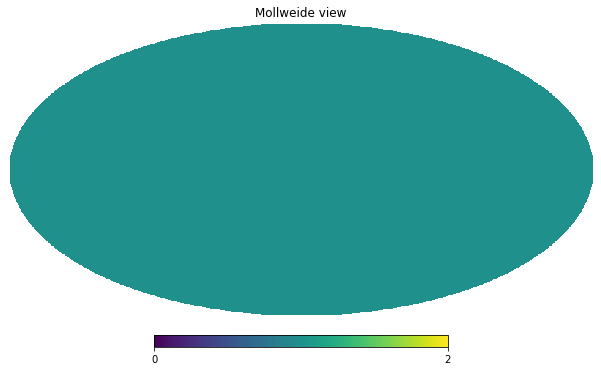

In [280]:
hp.mollview(As_all)

# test

In [168]:
import Loglikeli

In [190]:
import importlib
importlib.reload(Loglikeli)

<module 'Loglikeli' from '/global/u2/j/jianyao/foreground/Loglikeli.py'>

In [255]:
logL = Loglikeli.logLike(64, fres,[0,1,2,3,4], total_P, total_sigma, 100)

In [274]:
logL.index = 100

In [251]:
# for i in range(1,100):
#     if i%10 == 0:
#         print(i)

In [ ]:
# with Pool(cpu_count()-1) as executor:
        
#     sampler = dynesty.NestedSampler(logL.loglike, prior, npara, nlive=400, pool=executor, queue_size=cpu_count(), bootstrap = 0)
#     sampler.run_nested(dlogz = 0.1)
#     results = sampler.results

In [275]:
sampler = dynesty.NestedSampler(logL.loglike, prior, npara, nlive=400, bootstrap = 0)
sampler.run_nested(dlogz = 0.5)
results = sampler.results

iter: 2470 | +400 | bound: 7 | nc: 1 | ncall: 16455 | eff(%): 17.442 | loglstar:   -inf < -18.942 <    inf | logz: -24.246 +/-    nan | dlogz:  0.001 >  0.500                                        

Text(0.5, 0.98, 'Pixel 100')

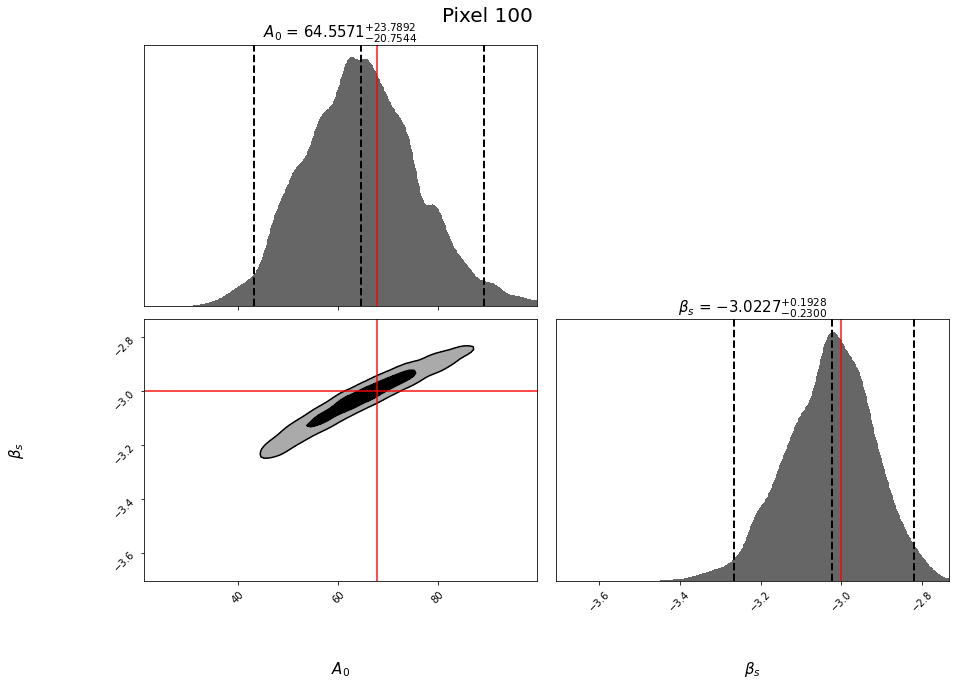

In [276]:
truth = np.array([P_nu0[logL.index], -3]);sig1 = [0.16, 0.5, 0.84]; sig2 = [0.021, 0.5, 0.979];


labels = ['$A_0$', r'$\beta_s$']; 
fig, axes = plt.subplots(npara, npara, figsize=(15, 10))
axes = axes.reshape((npara, npara)) 

fig, ax = dyplot.cornerplot(results, truths=truth, fig = (fig, axes), title_fmt='.4f', title_kwargs = {'fontsize':15},show_titles=True,
                 labels = labels, label_kwargs = {'fontsize':15}, quantiles = sig2, quantiles_2d = [0.4,0.85]) #0.1, 0.4, 0.65, 0.85
fig.suptitle("Pixel %s"%logL.index, fontsize="20")

In [196]:
samples, weights = results.samples, np.exp(results.logwt - results.logz[-1])

In [209]:
dynesty.utils.quantile(samples[:,1], [0.5], weights)

[-3.0232436894048997]

In [206]:
dynesty.utils.quantile(samples[:,0], sig2, weights)

[42.51413064803956, 64.39738969437843, 88.79334606500959]